In [1]:
from hamiltonian import HamiltonianSmall, Hamiltonian

In [2]:
lih_small = HamiltonianSmall('LiH', 1.5) # this encoding uses reduction techniques
beh2_small = HamiltonianSmall('BeH2', 1.3) # this encoding uses reduction techniques

# 4 qubits
h2_jw_4 = Hamiltonian('H2_STO3g_4qubits', 'jw')
h2_parity_4 = Hamiltonian('H2_STO3g_4qubits', 'parity')
h2_bk_4 = Hamiltonian('H2_STO3g_4qubits', 'bk')

# 8 qubits
h2_jw = Hamiltonian('H2_6-31G_8qubits', 'jw')
h2_parity = Hamiltonian('H2_6-31G_8qubits', 'parity')
h2_bk = Hamiltonian('H2_6-31G_8qubits', 'bk')

# 12 qubits
lih_jw = Hamiltonian('LiH_STO3g_12qubits', 'jw')
lih_parity = Hamiltonian('LiH_STO3g_12qubits', 'parity')
lih_bk = Hamiltonian('LiH_STO3g_12qubits', 'bk')

# 14 qubits
h2o_jw = Hamiltonian('H2O_STO3g_14qubits', 'jw')
h2o_parity = Hamiltonian('H2O_STO3g_14qubits', 'parity')
h2o_bk = Hamiltonian('H2O_STO3g_14qubits', 'bk')

beh2_jw = Hamiltonian('BeH2_STO3g_14qubits', 'jw')
beh2_parity = Hamiltonian('BeH2_STO3g_14qubits', 'parity')
beh2_bk = Hamiltonian('BeH2_STO3g_14qubits', 'bk')

# 16 qubits
nh3_jw = Hamiltonian('NH3_STO3g_16qubits', 'jw')
nh3_parity = Hamiltonian('NH3_STO3g_16qubits', 'parity')
nh3_bk = Hamiltonian('NH3_STO3g_16qubits', 'bk')

# 20 qubits
c2_jw = Hamiltonian('C2_STO3g_20qubits', 'jw')
c2_parity = Hamiltonian('C2_STO3g_20qubits', 'parity')
c2_bk = Hamiltonian('C2_STO3g_20qubits', 'bk')

In [3]:
hamiltonians = {"lih_small": lih_small,
                "beh2_small": beh2_small,
                "h2_jw_4": h2_jw_4,
                "h2_parity_4": h2_parity_4,
                "h2_bk_4": h2_bk_4,
                "h2_jw": h2_jw,
                "h2_parity": h2_parity,
                "h2_bk": h2_bk}

In [4]:
%time h2_jw_4.pauli_rep.ground()
%time h2_jw.pauli_rep.ground()
%time lih_jw.pauli_rep.ground()
%time energy, state = h2o_jw.pauli_rep.ground()
# %time energy, state = nh3_jw.pauli_rep.ground() # takes about 4 minutes

CPU times: user 20.6 ms, sys: 2.59 ms, total: 23.2 ms
Wall time: 21 ms
CPU times: user 505 ms, sys: 25.9 ms, total: 531 ms
Wall time: 419 ms
CPU times: user 4.58 s, sys: 401 ms, total: 4.98 s
Wall time: 2.76 s
CPU times: user 22 s, sys: 2.56 s, total: 24.5 s
Wall time: 10.2 s


In [5]:
%time h2_jw_4.pauli_rep.ground(multithread=True)
%time h2_jw.pauli_rep.ground(multithread=True)
%time lih_jw.pauli_rep.ground(multithread=True)
%time energy, state = h2o_jw.pauli_rep.ground(multithread=True)
# %time energy, state = ammonia_jw.pauli_rep.ground(multithread=True) # takes about 1 minute

CPU times: user 49.1 ms, sys: 49.1 ms, total: 98.1 ms
Wall time: 340 ms
CPU times: user 178 ms, sys: 90 ms, total: 268 ms
Wall time: 504 ms
CPU times: user 1.37 s, sys: 319 ms, total: 1.69 s
Wall time: 1.02 s
CPU times: user 22.2 s, sys: 3.03 s, total: 25.2 s
Wall time: 4.63 s


# Variance formula

\begin{align}
    \Var[\nu] 
    &=
    \sum_{\Qarrow,\Rarrow}
        f_\beta(\Qarrow,\Rarrow)
        \alpha_\Qarrow \alpha_\Rarrow
        \tr(\rho\Qarrow\Rarrow)
    - \tr(\rho H_0 )^2
\end{align}

In [6]:
ham = h2_jw_4
energy, state = ham.pauli_rep.ground()
β = ham.pauli_rep.local_dists_uniform()
%time ham.pauli_rep.variance_local(energy, state, β)

CPU times: user 23.3 ms, sys: 3.1 ms, total: 26.4 ms
Wall time: 3.31 ms


1.9710775636478903

In [7]:
print("ell_1: ", ham.pauli_rep.variance_ell_1(energy))

ell_1:  2.493466775932121


In [8]:
# this code is from an old idea, which ultimately did not work well.

β = ham.pauli_rep.local_dists_pnorm(1)
print("1_norm: ", ham.pauli_rep.variance_local(energy, state, β))

β = ham.pauli_rep.local_dists_pnorm(2)
print("2_norm: ", ham.pauli_rep.variance_local(energy, state, β))

β = ham.pauli_rep.local_dists_pnorm('infinity')
print("max_norm: ", ham.pauli_rep.variance_local(energy, state, β))

1_norm:  60.38753187541104
2_norm:  22.36573743732807
max_norm:  13.643445555482327


# Variance optimisation (method=diagonal)

This is not the correct optimisation. However it
- gives good results;
- is quicker than the full optimisation problem;
- is convex (so local minimums are global);
- does not need access to the Hartree-Fock bitstring for the encoding.

Diagonal minimisation asks us to find $\{\beta_{i,P}\}$ in order to minimise:
$$
    \sum_{\Qarrow} \alpha_\Qarrow^2 \prod_{i\in\supp(\Qarrow)} \beta_{i,Q_i}^{-1}
    \qquad
    \textrm{subject to}
    \qquad
    \beta_{i,X}+\beta_{i,Y}+\beta_{i,Z}=1 \,\forall i,
    \qquad
    \beta_{i,P}\ge 0
$$

And we have an implementation using Lagrange multipliers

In [9]:
β = ham.pauli_rep.local_dists_optimal('diagonal', 'scipy')
print(ham.pauli_rep.variance_local(energy, state, β))

1.8555808969284264


In [10]:
β = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange')
print(ham.pauli_rep.variance_local(energy, state, β))

1.855583049884943


In [11]:
# time comparison lih_jw has 12 qubits

ham = lih_jw
%time β_scipy = ham.pauli_rep.local_dists_optimal('diagonal', 'scipy')
%time β_lagrange = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange')

energy, state = ham.pauli_rep.ground(multithread=True)
%time var_scipy = ham.pauli_rep.variance_local(energy, state, β_scipy)
%time var_lagrange = ham.pauli_rep.variance_local(energy, state, β_lagrange)

discrepancy = abs(var_scipy - var_lagrange)
print("discrepancy between variances: ", discrepancy)

CPU times: user 1min 10s, sys: 8.78 s, total: 1min 19s
Wall time: 13.3 s
CPU times: user 1.65 s, sys: 92.9 ms, total: 1.74 s
Wall time: 1.17 s
discrepancy between variances:  4.9317204574350626e-05


# Variance optimisation (method=mixed)

This is the full optimisation problem. It requires access to the Hartree-Fock bitstring $m$ or `bitstring_HF` so that the HF state reads
$\frac1{2^n}\otimes_{i=1}^n (I+m_i Z)$

In the JW encoding these are:
- H2 = `1010` (on four qubits)
- H2 = `10001000`
- LiH = `100000100000`
- H2O = `11111001111100`
- BeH2 = `11100001110000`
- NH3 = `1111100011111000`
You can retrieve them by calling `Hamiltonian.read_bitstring_HF()`

Consider the set of influential pairs:
\begin{align}
    \mathcal{I}_\mathrm{comp}
    =
    \left\{\left.
        (\Qarrow,\Rarrow)
        \,\right|\,
        \textrm{for all $i$, either $Q_i=R_i$, or $\{Q_i,R_i\}=\{I,Z\}$}
    \right\}
\end{align}

Then the cost function to optimise will be:
\begin{align}
    \mathrm{cost}(\{\beta_i\}_{i=1}^n)
    =
    \sum_{\Qarrow,\Rarrow\in\mathcal{I}_\mathrm{comp}}
        \alpha_\Qarrow
        \alpha_\Rarrow
        \prod_{i | Q_i=R_i\neq I}
            \beta_{i,Q_i}^{-1}
        \prod_{i | Q_i\neq R_i}
            m_i
\end{align}

Warning, the small Hamiltonians don't follow the pattern because they use other reduction techniques

In [31]:
# time comparison lih_jw has 12 qubits

ham = lih_jw
bitstring_HF = ham.read_bitstring_HF()

%time β_scipy = ham.pauli_rep.local_dists_optimal('mixed', 'scipy', bitstring_HF=bitstring_HF)
%time β_lagrange = ham.pauli_rep.local_dists_optimal('mixed', 'lagrange', bitstring_HF=bitstring_HF)

energy, state = ham.pauli_rep.ground(multithread=True)
%time var_scipy = ham.pauli_rep.variance_local(energy, state, β_scipy)
%time var_lagrange = ham.pauli_rep.variance_local(energy, state, β_lagrange)

discrepancy = abs(var_scipy - var_lagrange)
print("discrepancy between variances: ", discrepancy)

CPU times: user 5min 41s, sys: 14.3 s, total: 5min 55s
Wall time: 4min 1s
CPU times: user 7.3 s, sys: 77.5 ms, total: 7.38 s
Wall time: 6.8 s
CPU times: user 21.9 s, sys: 527 ms, total: 22.4 s
Wall time: 21.6 s
CPU times: user 21 s, sys: 430 ms, total: 21.4 s
Wall time: 21.5 s
discrepancy between variances:  0.00016222318137693037


# Variance after LDF grouping

We should use 1-norm sampling for $\kappa$

\begin{align}
    \Var[\nu] 
    = 
    \left(
    \sum_{k=1}^{n_c}
        \frac1{\kappa_k} 
        \sum_{\Qarrow,\Rarrow\in C^{(k)}}
            \alpha_\Qarrow\alpha_\Rarrow
            \prod_{i\in\supp(\Qarrow\Rarrow)} \langle \Qarrow\Rarrow \rangle
    \right)
    - \langle H_0 \rangle^2
\end{align}

In [27]:
from var import variance_ldf, kappa_1norm #kappa_uniform

In [29]:
ham = h2_jw
energy, state = ham.pauli_rep.ground(multithread=True)

ldf = ham.ldf()
kappa = kappa_1norm(ldf)
energy_tf = ham.pauli_rep.energy_tf(energy)
variance_ldf(ldf, state, kappa, energy_tf)

22.25947792299107

# Benchmarking

In [15]:
def variances_dict(ham, β_diag=None, β_mix=None):
    pr = ham.pauli_rep
    dic = {}
    
    energy, state = pr.ground(multithread=True)
    print("energy :", energy)

    # ell_1
    var = pr.variance_ell_1(energy)
    print("ell 1: ", var)
    dic['ell_1'] = var
    
    # LDF with 1-norm sampling
    ldf = ham.ldf()
    kappa = kappa_1norm(ldf)
    energy_tf = pr.energy_tf(energy)
    var = variance_ldf(ldf, state, kappa, energy_tf)
    print("ldf 1norm: ", var)
    dic['ldf_1norm'] = var
    
    # uniform
    β_uniform = pr.local_dists_uniform()
    var = pr.variance_local(energy, state, β_uniform, multithread=True)
    print("uniform: ", var)
    dic['uniform'] = var
    
    # optimal (diagonal)
    if β_diag is not None:
        var = pr.variance_local(energy, state, β_diag, multithread=True)
        print("optimal diagonal: ", var)
        dic['optimal_diag'] = var
 
    # optimal (mixed)
    if β_mix is not None:
        var = pr.variance_local(energy, state, β_mix, multithread=True)
        print("optimal mixed: ", var)
        dic['optimal_mix'] = var
    
    return dic

from matplotlib import pyplot as plt

def variances_graph(variances):
    num_variances = len(variances)
    x = range(num_variances)
    height = list(variances.values())

    plt.bar(x, height)
    plt.xticks(x, list(variances.keys()), rotation=20)
    plt.title(title)

    plt.show()

In [16]:
variances_ALL = {}
beta_optimal_ALL = {}

In [17]:
import time

In [19]:
def benchmarking(name, ham, title):
    bitstring_HF = ham.read_bitstring_HF()
    
    t0 = time.time()
    β_diag = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange')
    t1 = time.time()
    print("β_diag found. Time taken: {} seconds".format(t1-t0))
    β_mix = ham.pauli_rep.local_dists_optimal('diagonal', 'lagrange', β_initial=β_diag, bitstring_HF=bitstring_HF)
    t2 = time.time()
    print("β_mix found.  Time taken: {} seconds".format(t2-t1))
    beta_optimal_ALL[name] = {'diagonal': β_diag, 'mixed': β_mix}
    
    variances_ALL[name] = variances_dict(ham, β_diag=β_diag, β_mix=β_mix)
    t3 = time.time()
    print("Variances calculated.  Time taken: {} seconds".format(t3-t2))
    
    print("=====")
    print(title)
    print("=====")
    print(variances_ALL[name])
    print("=====")
    
    variances_graph(variances_ALL[name])  

β_diag found. Time taken: 0.011924028396606445 seconds
β_mix found.  Time taken: 0.0006928443908691406 seconds
energy : -1.8572750302023824
ell 1:  2.493466775932119
ldf 1norm:  0.4018197080691297
uniform:  1.97107756364789
optimal diagonal:  1.8555830498849433
optimal mixed:  1.8555827209682574
Variances calculated.  Time taken: 1.534156084060669 seconds
=====
Variances for various algorithms on H2 in JW encoding over 4 qubits
=====
{'ell_1': 2.493466775932119, 'ldf_1norm': 0.4018197080691297, 'uniform': 1.97107756364789, 'optimal_diag': 1.8555830498849433, 'optimal_mix': 1.8555827209682574}
=====


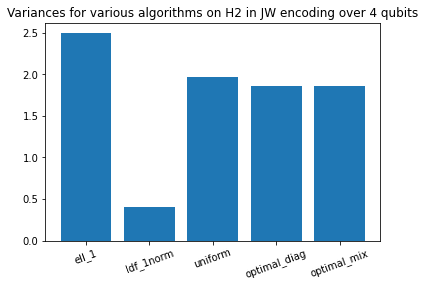

In [32]:
name = 'h2_jw_4'
ham = h2_jw_4
title = "Variances for various algorithms on H2 in JW encoding over 4 qubits"

benchmarking(name, ham, title)

β_diag found. Time taken: 0.15977001190185547 seconds
β_mix found.  Time taken: 0.021544933319091797 seconds
energy : -1.8608605555207616
ell 1:  119.67906001905908
ldf 1norm:  22.25947792299109
uniform:  51.39982021387577
optimal diagonal:  17.74194781113711
optimal mixed:  17.741971129500563
Variances calculated.  Time taken: 2.04364013671875 seconds
=====
Variances for various algorithms on H2 in JW encoding over 8 qubits
=====
{'ell_1': 119.67906001905908, 'ldf_1norm': 22.25947792299109, 'uniform': 51.39982021387577, 'optimal_diag': 17.74194781113711, 'optimal_mix': 17.741971129500563}
=====


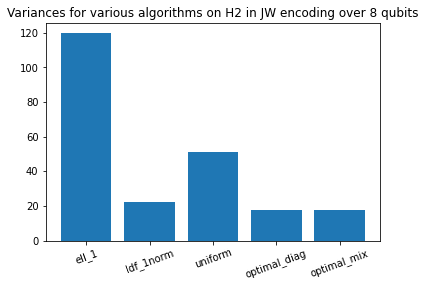

In [33]:
name = 'h2_jw'
ham = h2_jw
title = "Variances for various algorithms on H2 in JW encoding over 8 qubits"

benchmarking(name, ham, title)

β_diag found. Time taken: 1.1438968181610107 seconds
β_mix found.  Time taken: 0.24379515647888184 seconds
energy : -8.908299431473589
ell 1:  138.3801809098668
ldf 1norm:  54.15086386372398
uniform:  265.63532330207937
optimal diagonal:  14.79275190849935
optimal mixed:  14.792744892880195
Variances calculated.  Time taken: 16.038710832595825 seconds
=====
Variances for various algorithms on LiH in JW encoding over 12 qubits
=====
{'ell_1': 138.3801809098668, 'ldf_1norm': 54.15086386372398, 'uniform': 265.63532330207937, 'optimal_diag': 14.79275190849935, 'optimal_mix': 14.792744892880195}
=====


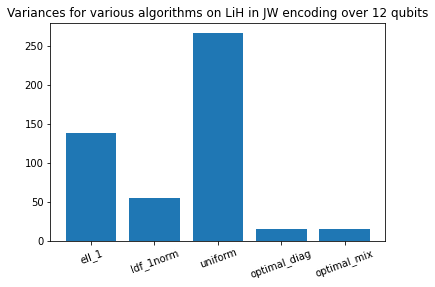

In [34]:
name = 'lih_jw'
ham = lih_jw
title = "Variances for various algorithms on LiH in JW encoding over 12 qubits"

benchmarking(name, ham, title)

In [ ]:
name = 'h2o_jw'
ham = h2o_jw
title = "Variances for various algorithms on H2O in JW encoding over 14 qubits"

benchmarking(name, ham, title)

In [ ]:
name = 'beh2_jw'
ham = beh2_jw
title = "Variances for various algorithms on BeH2 in JW encoding over 14 qubits"

benchmarking(name, ham, title)

In [ ]:
# mac book pro is too weak for this!

#name = 'nh3_jw'
#ham = nh3_jw
#title = "Variances for various algorithms on NH3 in JW encoding over 16 qubits"

In [ ]:
def save_variances_graph(variances, title, name):
    num_variances = len(variances)
    x = range(num_variances)
    height = list(variances.values())

    plt.bar(x, height)
    plt.xticks(x, list(variances.keys()), rotation=20)
    plt.title(title)

    file = '../images/5algos_jw_encoding/{}'.format(name)
    plt.savefig(file, dpi=300)
    plt.show()

In [ ]:
graph_data = {"h2_jw_4": [variances_ALL["h2_jw_4"], 
                          "Variances for various algorithms on H2 in JW encoding over 4 qubits",
                          "h2_jw_4q_1min"],
              "h2_jw": [variances_ALL["h2_jw"], 
                        "Variances for various algorithms on H2 in JW encoding over 8 qubits",
                        "h2_jw_8q_1min"],
              "lih_jw": [variances_ALL["lih_jw"], 
                         "Variances for various algorithms on LiH in JW encoding over 12 qubits",
                         "lih_jw_12q_5min"],
              "h2o_jw": [variances_ALL["h2o_jw"], 
                         "Variances for various algorithms on H2O in JW encoding over 14 qubits",
                         "h2o_jw_14q_20min"],
              "beh2_jw": [variances_ALL["beh2_jw"], 
                          "Variances for various algorithms on BeH2 in JW encoding over 14 qubits",
                          "beh2_jw_14q_14min"]}

In [ ]:
#for data in graph_data.values():
#    save_variances_graph(*data)